## functions

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore,ttest_ind,ttest_rel,pearsonr,spearmanr,wilcoxon

sns.set(font_scale=1.5,style="white")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [3]:
from time import time
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pingouin as pg

### load data

In [35]:
bold_path = '/data/dy/TIS_MDD/BOLD'
sub_ls = os.listdir(bold_path)

Top_fc_path = '/data/dy/TIS_MDD/HAC/Top_fc'
print(f"number of subjects：{len(sub_ls)}")

number of subjects：31


In [5]:
demo_info = pd.read_csv('/data/dy/TIS_MDD/demo_info.csv',index_col=0)
demo_info['sub_id'] = demo_info.index
demo_info['sex_id'] = [1 if i=='M' else 0 for i in demo_info['sex']]

def fun_add_demo_time(data,run_label):
    data = pd.concat([data,demo_info],axis=1)
    data['time'] = [run_label for i in range(data.shape[0])]
    data = data.dropna(axis=0)
    return data

def fun_concat(data1,data2):
    common_index = data1.index.intersection(data2.index)
    data = pd.concat([data1.loc[common_index,:],data2.loc[common_index,:]])
    return data

In [36]:
def fun_match_scale(scale,timepoint):
    result = pd.DataFrame([])
    df = scale.copy()
    process = df[df['condition'] == timepoint]
    for sub in sub_ls:
        if(sub in process.index):
            result = pd.concat([result,process.loc[sub,:]],axis=1)
    return result.T

def fun_scale_change(scale,col_name,after_label):
    df = pd.concat([fun_match_scale(scale,'pre')[col_name],fun_match_scale(scale,after_label)[col_name]],axis=1).dropna(axis=0)
    df.columns = ['baseline','!baseline']
    df = pd.DataFrame(df['!baseline']-df['baseline'],columns=['scale'])
    return df

madrs = pd.read_csv('/data/dy/TIS_MDD/Scales/madrs.csv',index_col='sub') ## MADRS_all
gad7 = pd.read_csv('/data/dy/TIS_MDD/Scales/gad7.csv',index_col='sub') ## GAD7_ALL
hama = pd.read_csv('/data/dy/TIS_MDD/Scales/hama.csv',index_col='sub') ## HAMA_all
hamd = pd.read_csv('/data/dy/TIS_MDD/Scales/hamd.csv',index_col='sub') ## HAMD_all
phq9 = pd.read_csv('/data/dy/TIS_MDD/Scales/phq9.csv',index_col='sub') ## PHQ9_ALL
psqi = pd.read_csv('/data/dy/TIS_MDD/Scales/psqi.csv',index_col='sub') ## PSQI_ALL 
qids = pd.read_csv('/data/dy/TIS_MDD/Scales/qids.csv',index_col='sub') ## QIDS_all
sf36 = pd.read_csv('/data/dy/TIS_MDD/Scales/sf36.csv',index_col='sub') ## SF36_all 
shaps = pd.read_csv('/data/dy/TIS_MDD/Scales/shaps.csv',index_col='sub') ## SHAPS_all
shaps['condition'] = shaps['target']

In [37]:
def get_sub_id(run_label):
    index_ls = []
    for sub in sub_ls:
        if(len(os.listdir(os.path.join(bold_path,sub,run_label)))!=0):
            index_ls.append(sub)
    return index_ls

### responder

In [38]:
def get_responder(scale,col_name,time_label):
    run_label = '5th_after' if time_label=='5th' else '4weeks'
    sub_id = get_sub_id(run_label)

    baseline = pd.DataFrame(fun_match_scale(scale,'pre')[col_name])
    process = pd.DataFrame(fun_match_scale(scale,time_label)[col_name])
    
    threshold = baseline*0.5
    common_index = process.index.intersection(threshold.index)
    process = process.loc[common_index,:];threshold = threshold.loc[common_index,:]
    responder = process<=threshold
    
    responder = responder.loc[responder.index.intersection(sub_id),:]
    
    responder.columns=['responde']
    return responder

### rs-FC

In [150]:
def p_star(p):
    if(p>0.05):
        return 'n.s.'
    elif(p>0.01):
        return '*'
    elif(p>0.001):
        return '**'
    else:
        return '***'

In [247]:
import statsmodels.formula.api as smf
import ptitprince as pt

res_colors = ['#E6194B','#4363D8']
def get_rsFC_change(rsFC,rsn_y,time_label):
    process_label = '5th_after'if time_label=='5th' else '4weeks'
    
    df = rsFC[rsFC['rsn_y']==rsn_y].drop_duplicates()
    
    fc0 = df[df['time']=='baseline'];fc1 = df[df['time']==process_label]
    common_index = fc0.index.intersection(fc1.index)
    fc_change = pd.DataFrame(fc1.loc[common_index,'FC']-fc0.loc[common_index,'FC'])
    return fc_change

time_label = '4week'
rsn_y = 'SalVentAttn'
scale = qids.copy()
col_name = 'QIDS_all'
def check_responder_effect(time_label,scale,col_name,rsn_y,responder,x_label=None):
    res_colors = ['#E6194B','#4363D8']
    
    responder['responde'] = ['responde' if i else 'non-responde' for i in responder['responde']]
    
    fc_change = get_rsFC_change(rsFC,rsn_y,time_label)
    
    scale_change = fun_scale_change(scale,col_name,time_label)
    
    df = pd.concat([fc_change,responder,scale_change,demo_info],axis=1).dropna(axis=0)
    df['scale'] = df['scale'].astype(np.float32) 
    
    t,p = ttest_ind(df[df['responde']=='responde']['FC'],df[df['responde']!='responde']['FC'])
    result = smf.ols('FC ~ responde + sex + age', data=df).fit();t = result.tvalues[1];p = result.pvalues[1]
    
    
    title_ = 'D5-post' if time_label=='5th' else 'W4'
    fig, ax = plt.subplots(figsize=(4,4),dpi=300)
    pt.RainCloud(x='responde', y='FC', data=df, order=['responde','non-responde'], palette=res_colors,
                         bw=.2, width_viol=1, width_box=.4, offset=.25,alpha=.75, move=-0.0, ax=ax, orient='v',point_size=4)
    y_max = np.max(df['FC']);y_min = np.min(df['FC']);y_range = y_max-y_min
    plt.xlim(-.9,1.5);plt.ylim(y_min-0.1*y_range,y_max+.2*y_range)
    plt.axhline(0,color='red',linestyle='--',alpha=0.5)
    print(f"T={t:.2f},p={p:.3f}")
    plt.text(0.3,y_max+y_range*0.15,p_star(p),ha='center',va='center',fontsize=15)
    plt.plot([-.2,-.2,.8,.8],[y_max+y_range*0.07,y_max+y_range*0.12,y_max+y_range*0.12,y_max+y_range*0.07],linewidth=1,color='black')
    plt.xticks([-0.3,.9],['responder','non-responder'],rotation=10,fontsize=17)
    plt.title(f"D0→{title_}",y=1.05)
    plt.xlabel('');plt.ylabel(f"ΔFC (Default-{rsn_y})",fontsize=17)
    plt.show()
    df['scale'] = np.array(df['scale']).astype(np.float32)
    partial_corr = pg.partial_corr(data=df,x="FC",y="scale",covar=["age","sex_id"],method="spearman" )
    r,p = partial_corr.loc['spearman',['r','p-val']]
    print(f"r={r:.2f}, p={p:.3f}")
    if(p<=0.2):
        c_line = '#38a8c5' if time_label=='5th' else '#cc79f4'
        y =np.array(df['scale']).astype(np.float64);x=np.array(df['FC']).astype(np.float64)
        
        ax=plt.figure(figsize=(6,4),dpi=300)
        sns.regplot(x=x, y=y,ci=95, 
                    scatter_kws={"facecolors": "#262626","edgecolor": "#262626","s": 20,'alpha':0},
                    line_kws={"color": c_line})
        plt.scatter(data=df[df['responde']=='responde'],x='FC',y='scale',color=res_colors[0],label='responder',s=30)
        plt.scatter(data=df[df['responde']!='responde'],x='FC',y='scale',color=res_colors[1],label='non-responder',s=30)
        
        x_max = np.max(x);x_min = np.min(x);x_range=x_max-x_min
        y_max = np.max(y);y_min = np.min(y);y_range=y_max-y_min
        
        y_text = y_min+y_range*.05;x_text = x_max-x_range*.2
        plt.text(x_text,y_text,f"r={r:.3f}\np={p:.3f}",ha='left', va='bottom')
        
        plt.xlim(x_min-x_range*.1,x_max+x_range*.1)
        plt.ylim(y_min-y_range*.05,y_max+y_range*.05)

        if(x_label==None):
            x_label = f"ΔFC (Default-{rsn_y})"
        plt.ylabel(f'Δ{col_name[:-4]} (D0→{title_})',fontsize=17);plt.xlabel(x_label,fontsize=17)
        plt.yticks(fontsize=15);plt.xticks(fontsize=15)
        legend = ax.legend(bbox_to_anchor=(0.1, 1.05), loc='upper left', frameon=False,handlelength=0.8,handletextpad=0.3,ncol=2)
        return df

## 分析、画图

In [270]:
schaefer = '100'
n_roi = int(schaefer)+19
upper_mask = np.triu(np.ones((n_roi, n_roi), dtype=bool), k=1)

rsFC = pd.read_csv(f"/data/dy/TIS_MDD/FC_change/Default_{schaefer}.csv")
rsFC.index = rsFC['sub_id']

In [263]:
responder = get_responder(hamd,'HAMD_all','4week')

T=-2.85,p=0.009


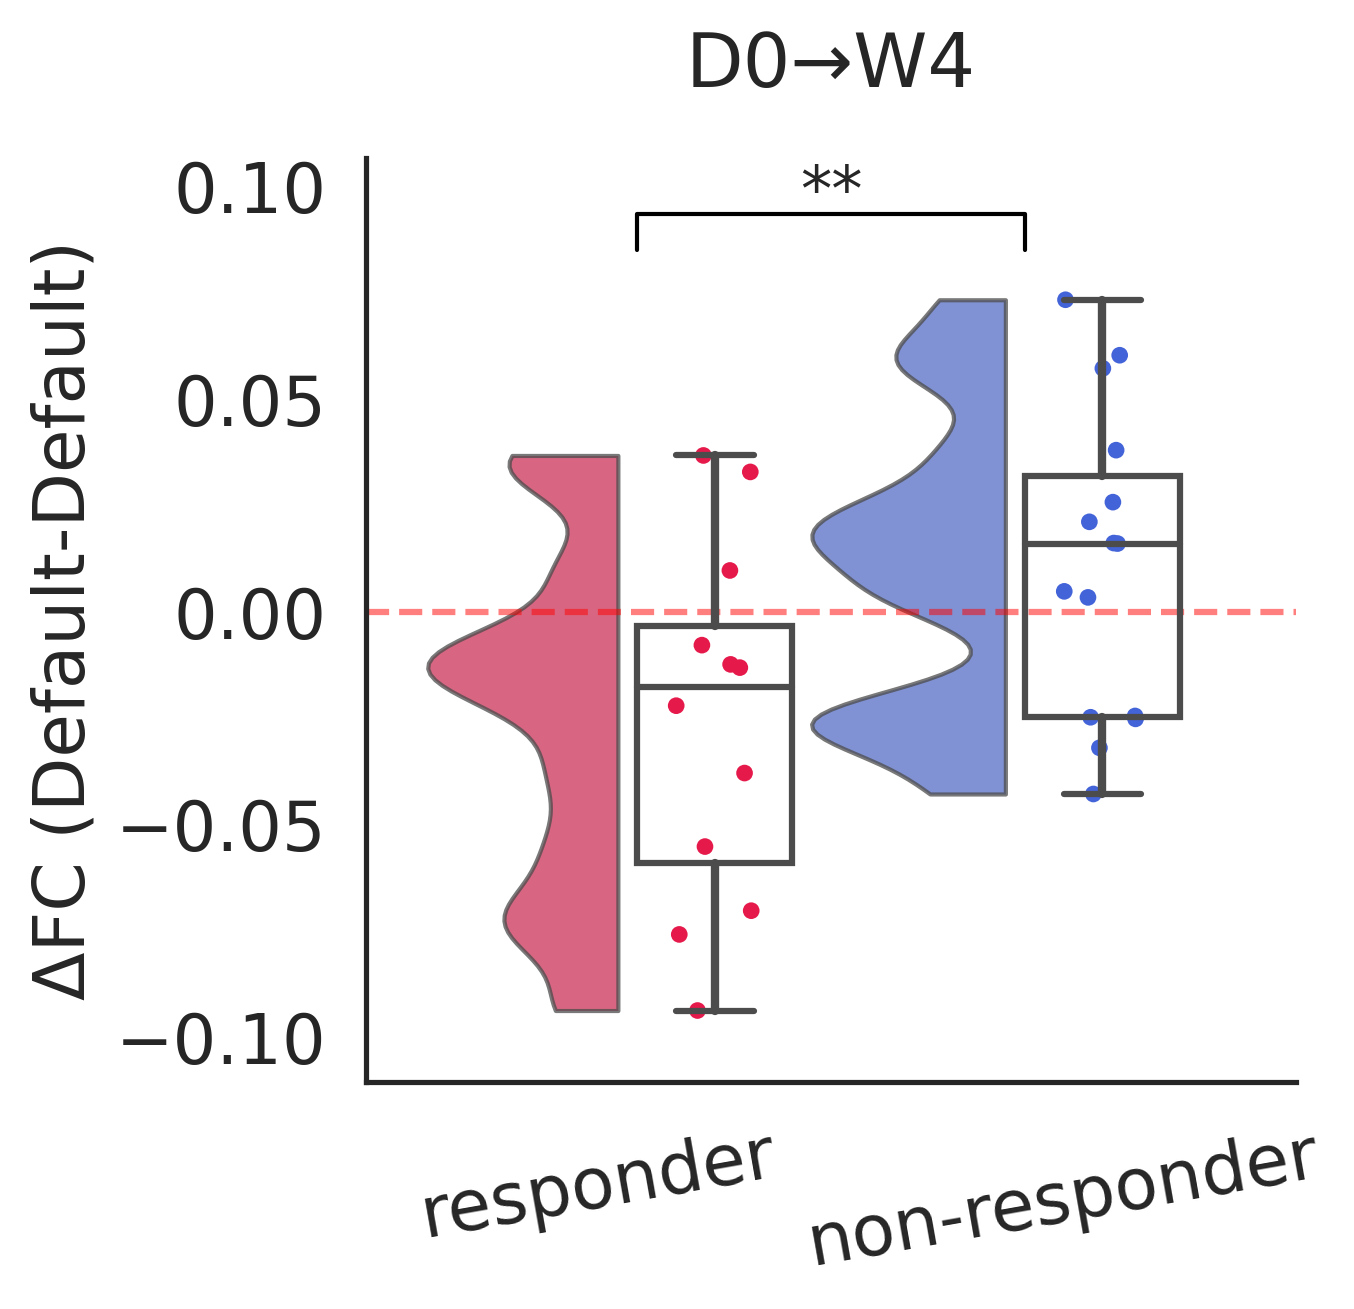

r=0.34, p=0.096


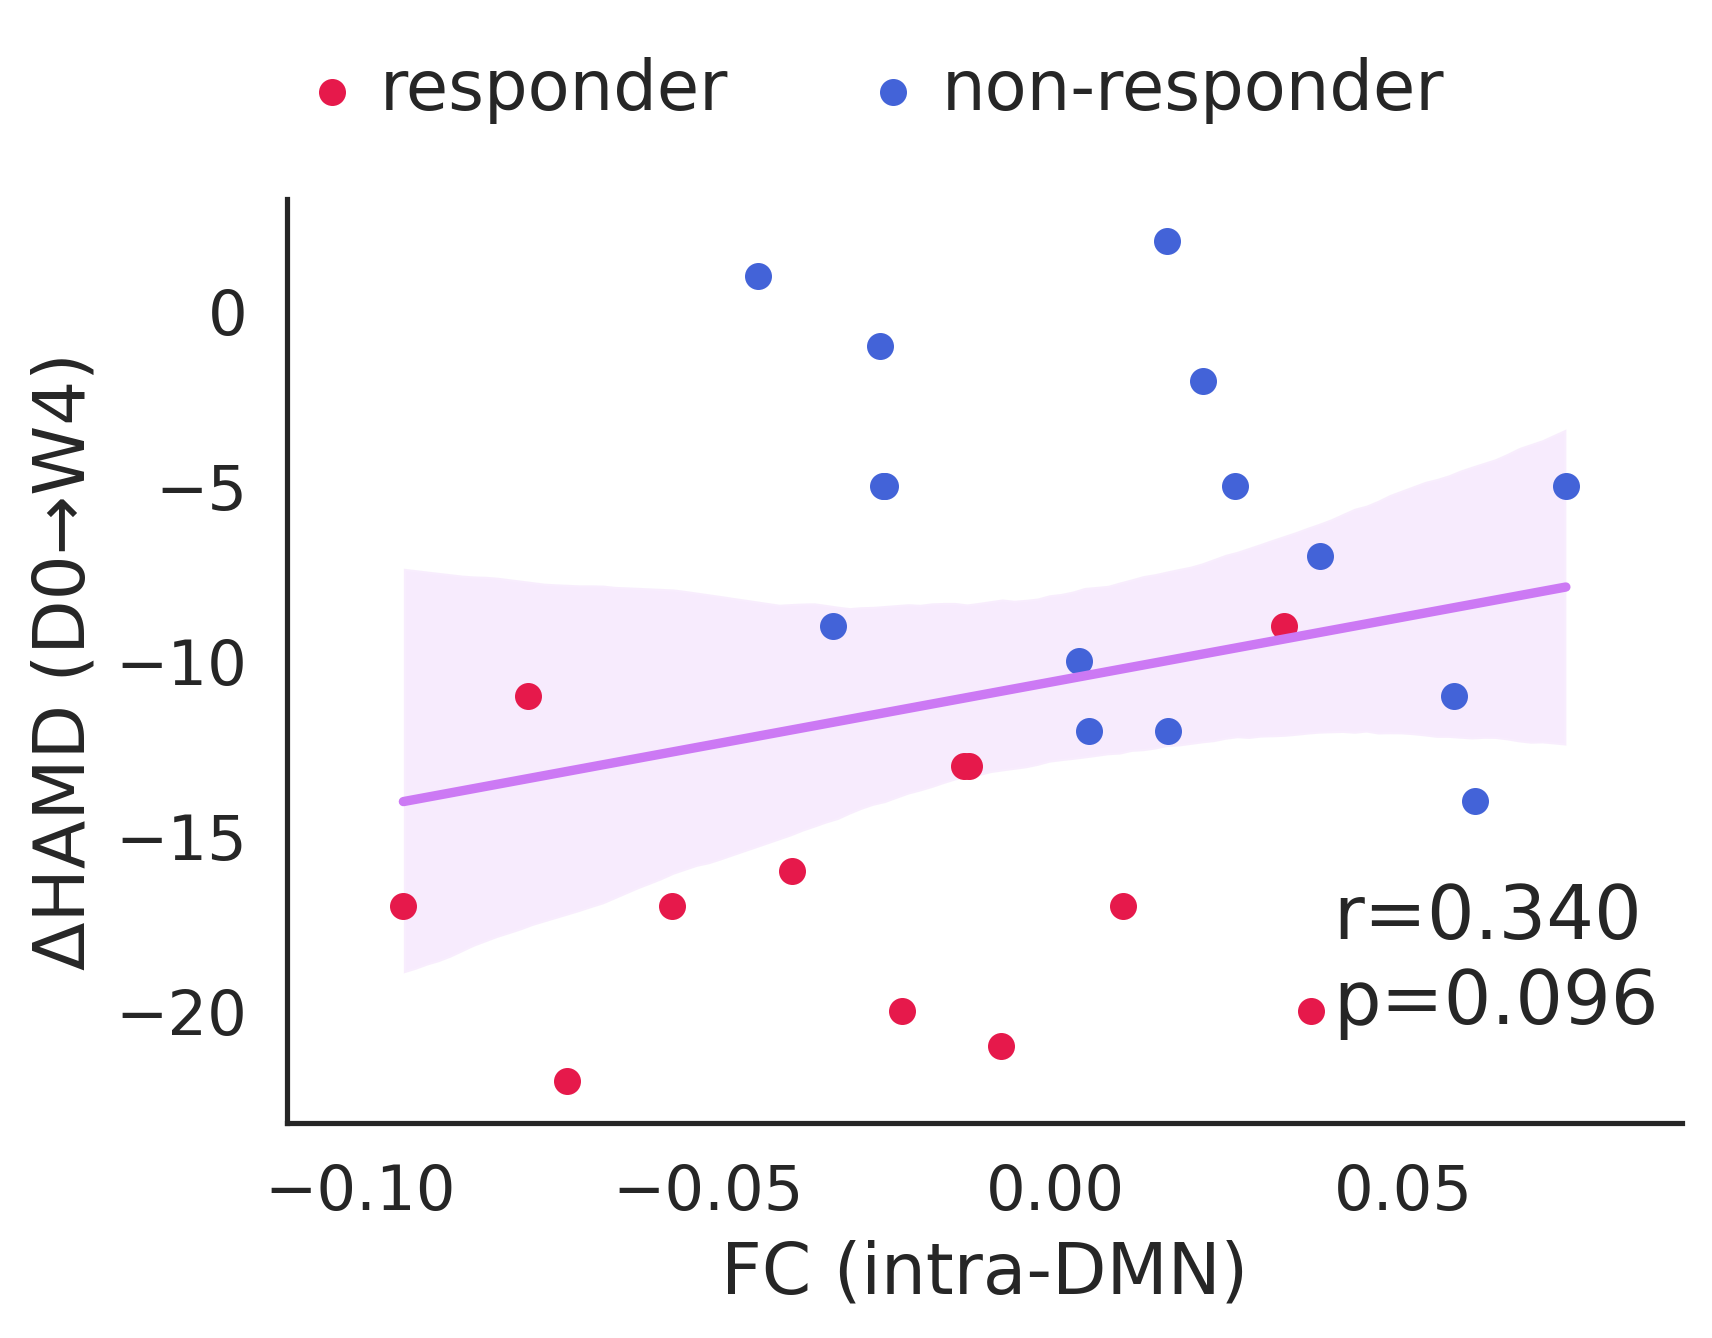

In [267]:
time_label = '4week';rsn_y = 'Default'
scale = hamd.copy();col_name = 'HAMD_all'
responder = get_responder(hamd,'HAMD_all','4week')
df = check_responder_effect(time_label,scale,col_name,rsn_y,responder,x_label='FC (intra-DMN)')
#df.to_excel(f"~/2025/MDD-tTIS/Code/xlsx/05_{rsn_y}_{col_name}_{time_label}.xlsx",index=False)

T=3.27,p=0.003


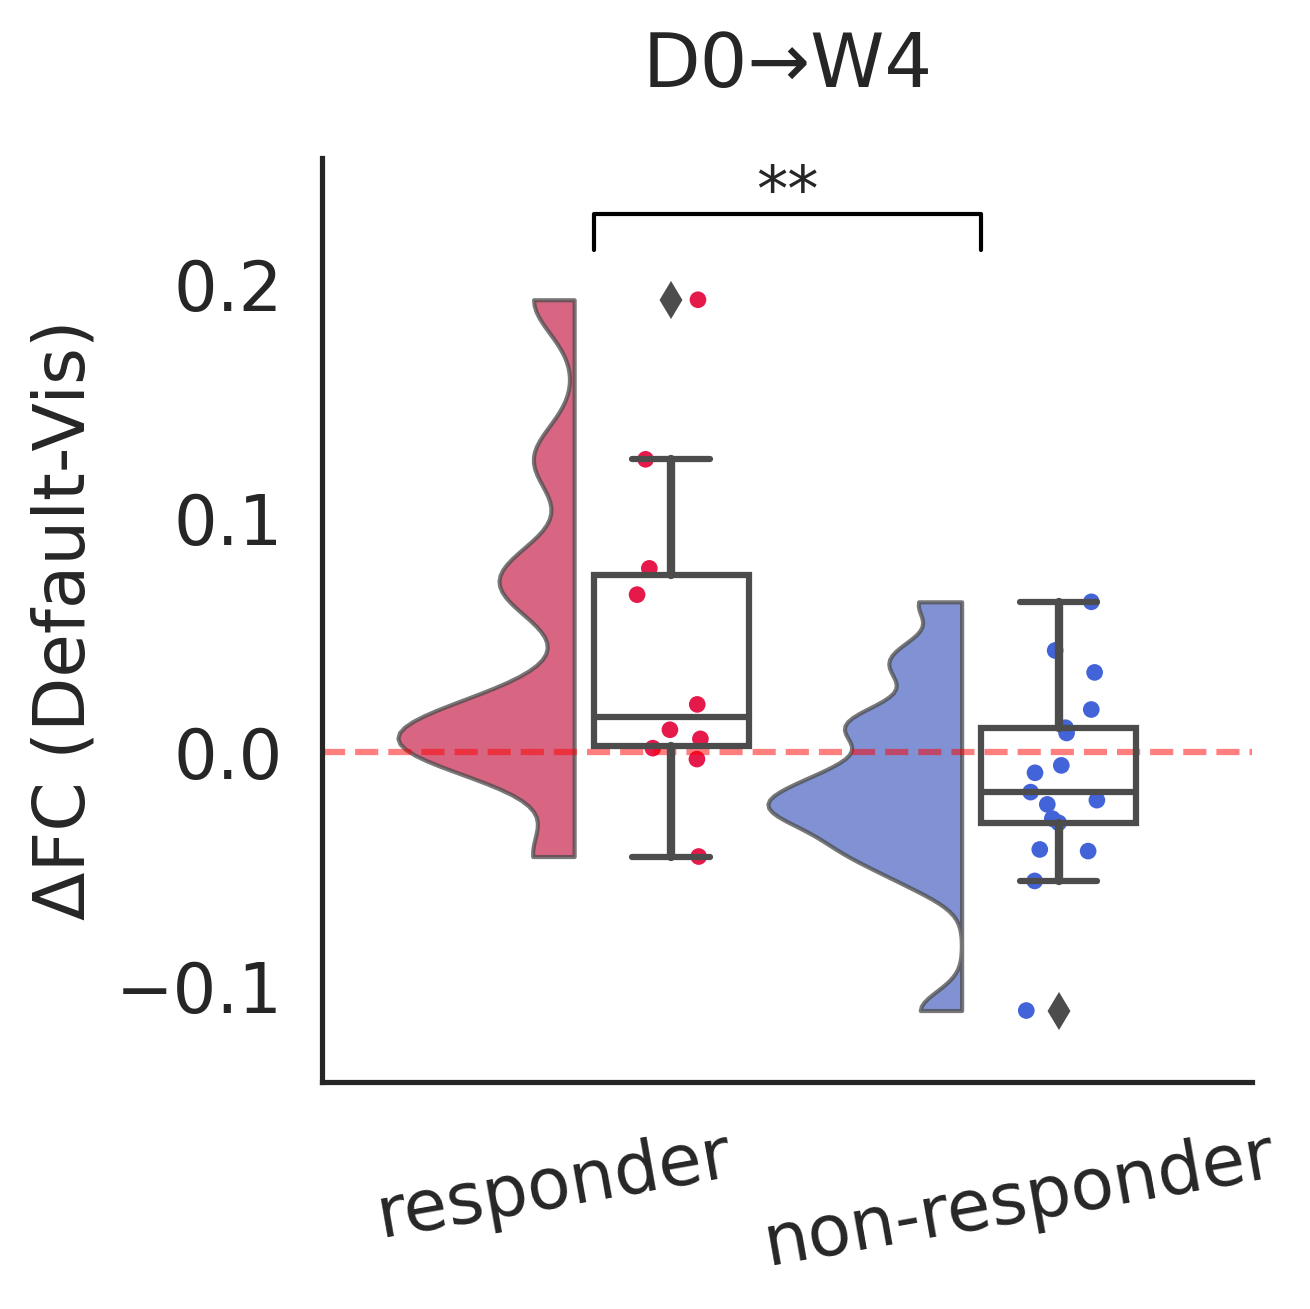

r=-0.46, p=0.021


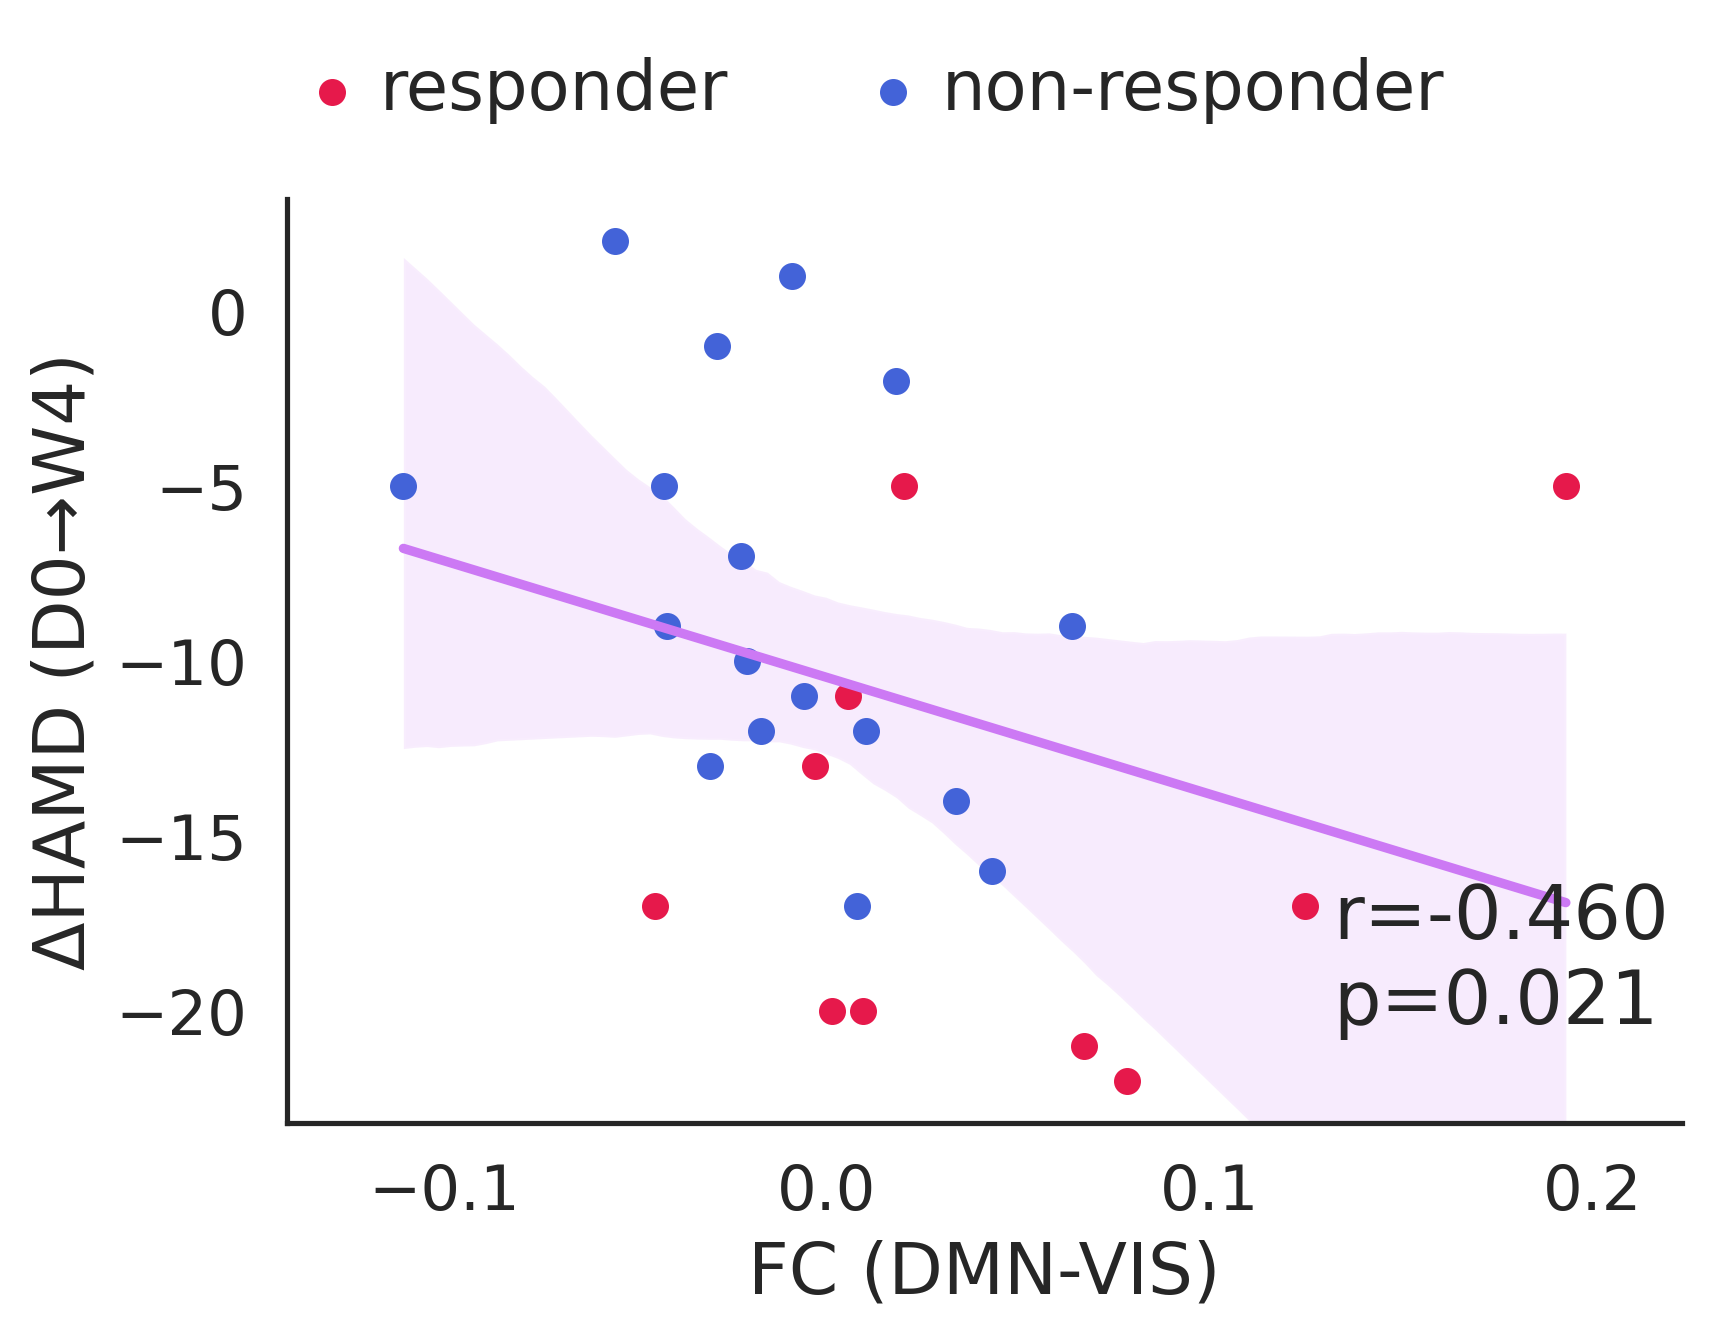

In [268]:
time_label = '4week';rsn_y = 'Vis'
scale = hamd.copy();col_name = 'HAMD_all'
responder = get_responder(qids,'QIDS_all','4week')
df = check_responder_effect(time_label,scale,col_name,rsn_y,responder,x_label='FC (DMN-VIS)')
#df.to_excel(f"~/2025/MDD-tTIS/Code/xlsx/05_{rsn_y}_{col_name}_{time_label}.xlsx",index=False)

T=3.27,p=0.003


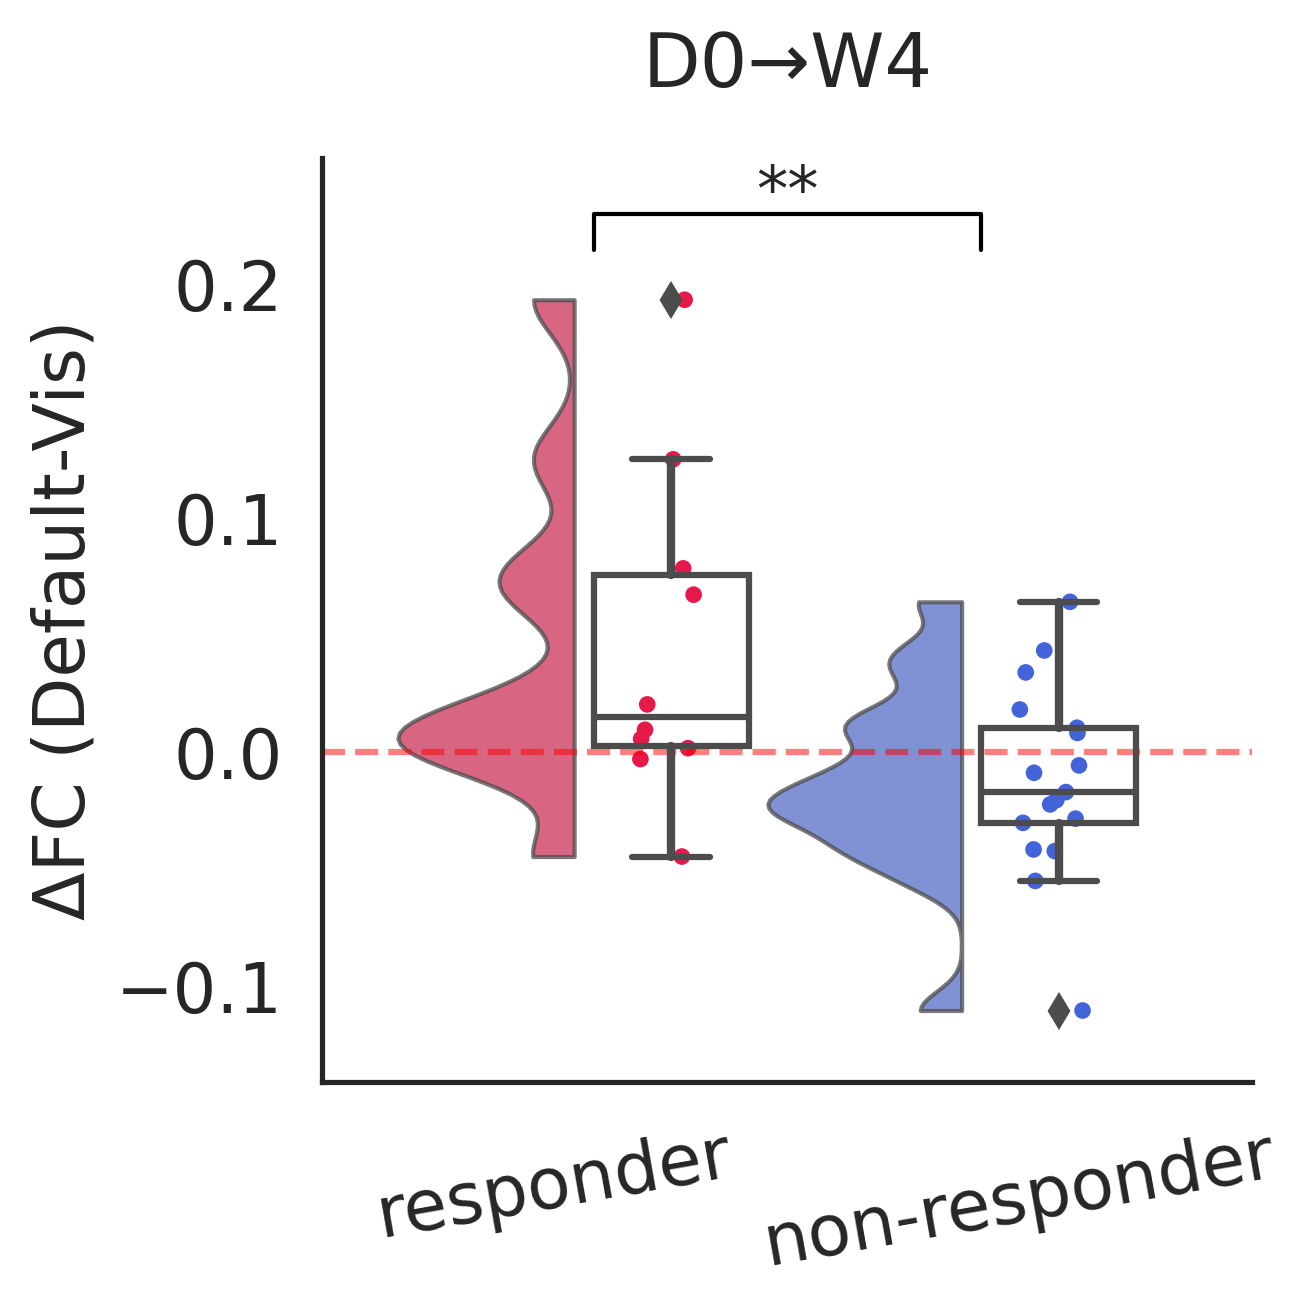

r=-0.48, p=0.015


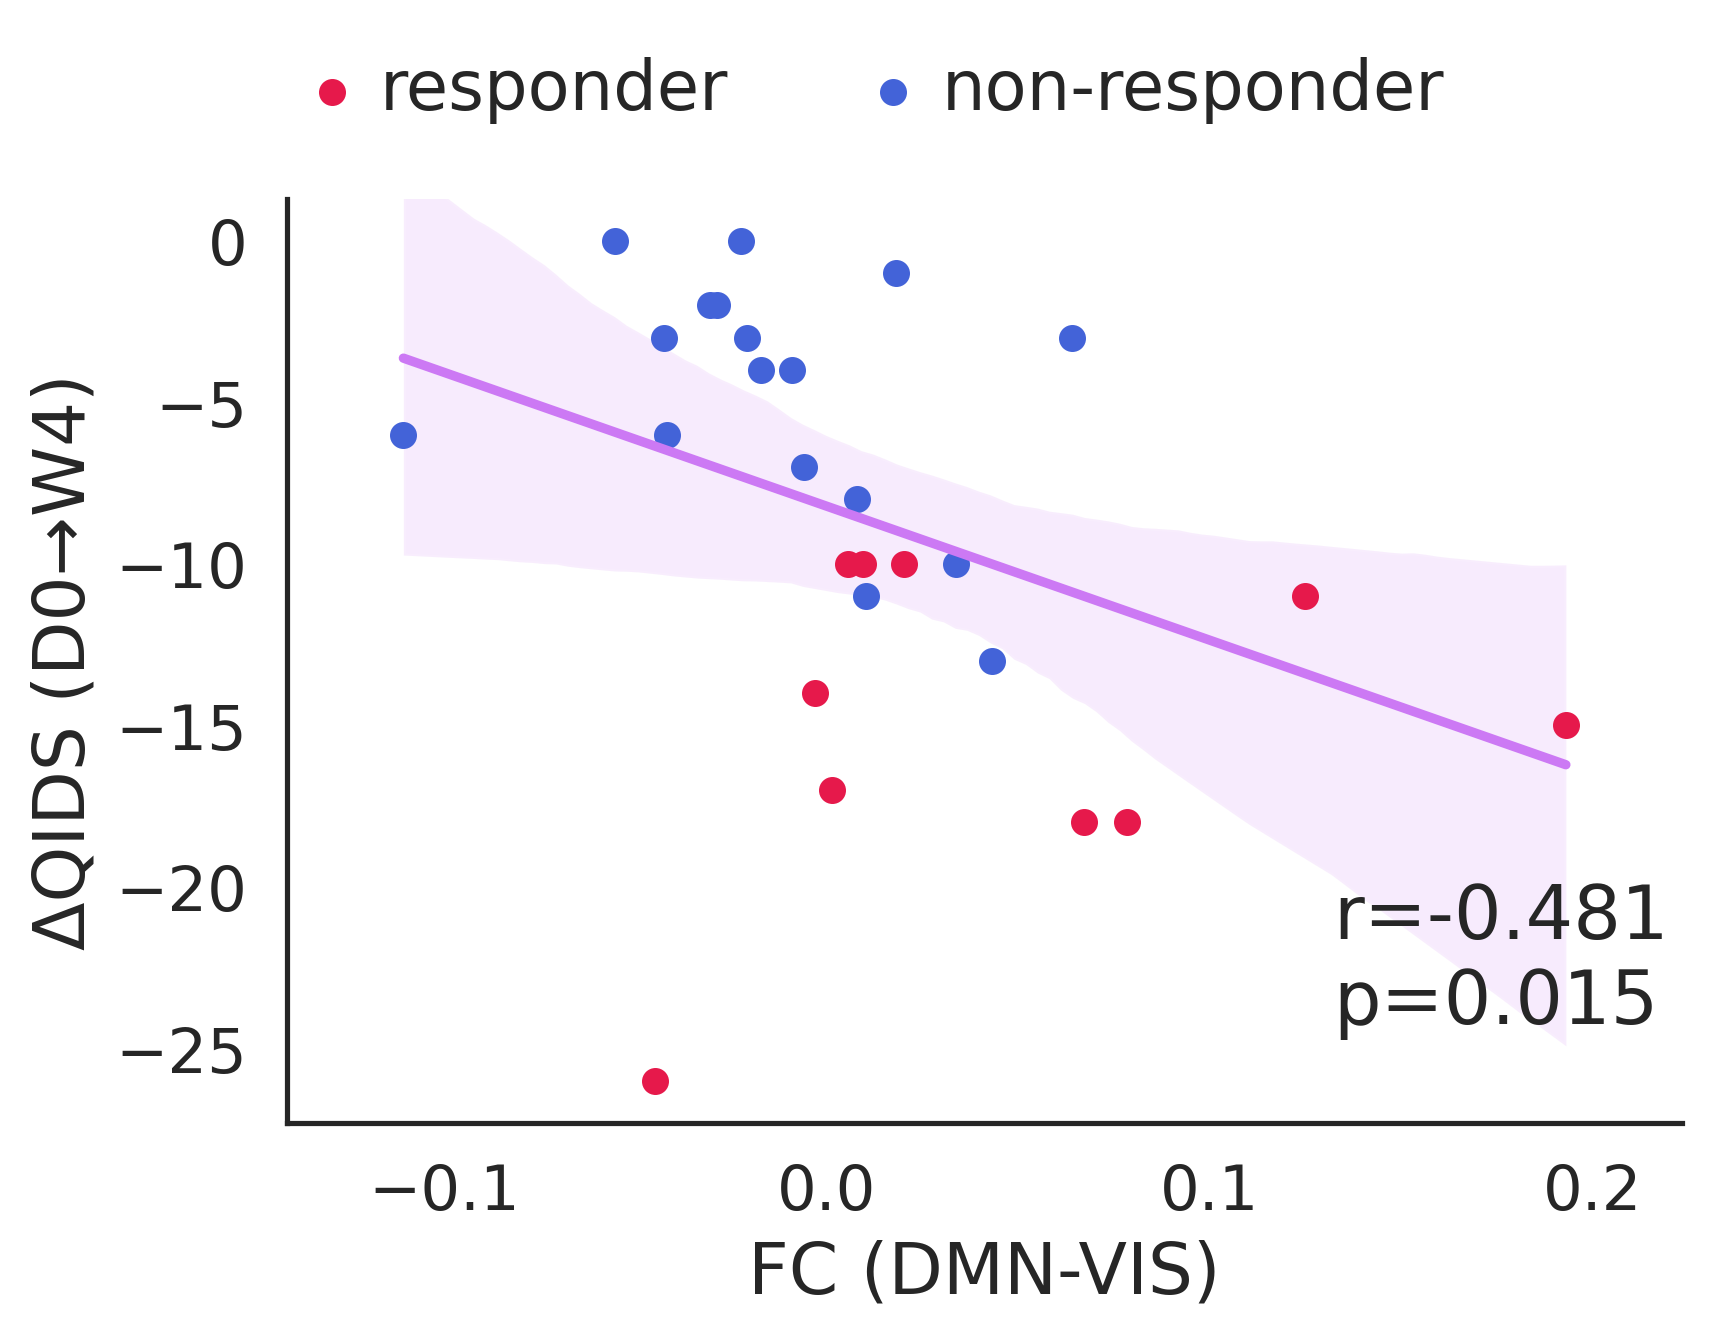

In [269]:
time_label = '4week';rsn_y = 'Vis'
scale = qids.copy();col_name = 'QIDS_all'
responder = get_responder(qids,'QIDS_all','4week')
df = check_responder_effect(time_label,scale,col_name,rsn_y,responder,x_label='FC (DMN-VIS)')
#df.to_excel(f"~/2025/MDD-tTIS/Code/xlsx/05_{rsn_y}_{col_name}_{time_label}.xlsx",index=False)

## R code